# Fraud Detection Using Voting Ensemble

This notebook builds an improved fraud detection model using a voting ensemble
to increase recall and robustness on high-risk transactions.


## 1. Imports and Setup


In [22]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    auc,
)

import lightgbm as lgb
import joblib
import warnings
warnings.filterwarnings("ignore")


## 2. Load Dataset


In [23]:
df = pd.read_csv("../data/Fraud.csv")
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## 3. Feature Engineering

We create behavioral features that better capture fraud patterns:
- Merchant destination flag
- Balance deltas
- Log-scaled transaction amount


In [24]:

df["isMerchantDest"] = df["nameDest"].str.startswith("M").astype(int)
df = df.drop(columns=["nameOrig", "nameDest"])
df["deltaOrig"] = df["oldbalanceOrg"] - df["newbalanceOrig"]
df["deltaDest"] = df["newbalanceDest"] - df["oldbalanceDest"]
df["log_amount"] = np.log1p(df["amount"])


## 4. Encode Categorical Variables


In [25]:
encoder = OrdinalEncoder()
df[["type"]] = encoder.fit_transform(df[["type"]])


In [26]:
df[["type"]] = encoder.fit_transform(df[["type"]])


## 5. Time-Aware Train-Test Split

Fraud evolves over time, so we split chronologically instead of randomly.


In [27]:
df = df.sort_values("step")

X = df.drop(columns=["isFraud"])
y = df["isFraud"]

split_idx = int(len(df) * 0.80)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]


## Exploratory Data Analysis

This section explores transaction behavior and fraud patterns using visual analysis.


### 5.1 Fraud vs Non-Fraud Count

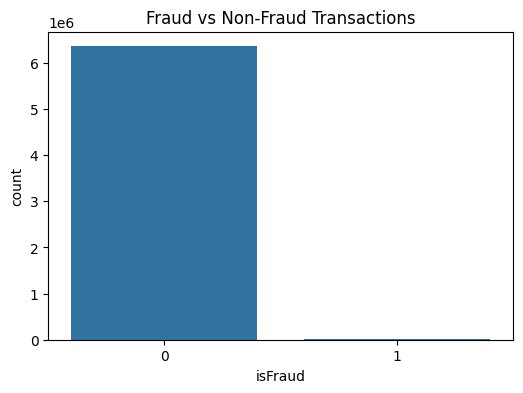

In [28]:
plt.figure(figsize=(6,4))
sns.countplot(x="isFraud", data=df)
plt.title("Fraud vs Non-Fraud Transactions")
plt.show()




### 5.2 Transaction Amount Distribution by Fraud Label


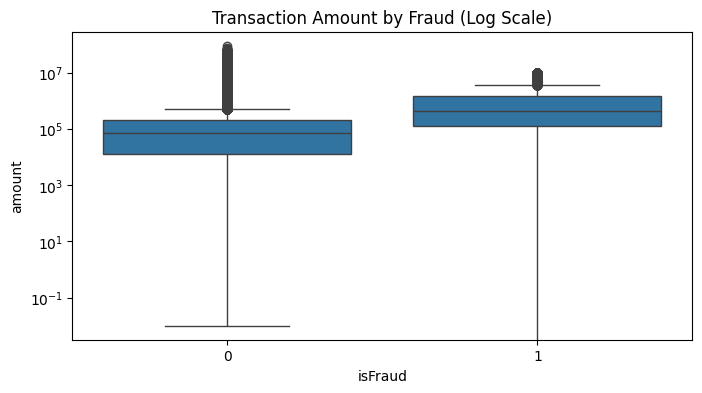

In [29]:
plt.figure(figsize=(8,4))
sns.boxplot(x="isFraud", y="amount", data=df)
plt.yscale("log")
plt.title("Transaction Amount by Fraud (Log Scale)")
plt.show()



### 5.3 Fraud Rate by Transaction Type


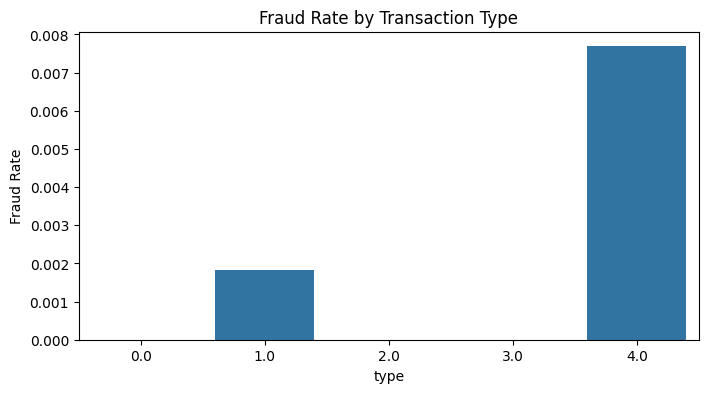

In [30]:
type_fraud = (
    df.groupby("type")["isFraud"]
    .mean()
    .reset_index()
    .sort_values("isFraud", ascending=False)
)

plt.figure(figsize=(8,4))
sns.barplot(x="type", y="isFraud", data=type_fraud)
plt.title("Fraud Rate by Transaction Type")
plt.ylabel("Fraud Rate")
plt.show()



### 5.4 Origin Account Balance Change


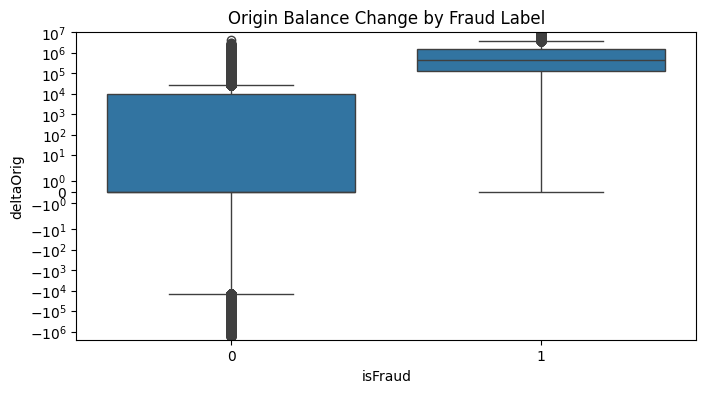

In [31]:
plt.figure(figsize=(8,4))
sns.boxplot(x="isFraud", y="deltaOrig", data=df)
plt.yscale("symlog")
plt.title("Origin Balance Change by Fraud Label")
plt.show()



### 5.5 Log Transaction Amount Distribution


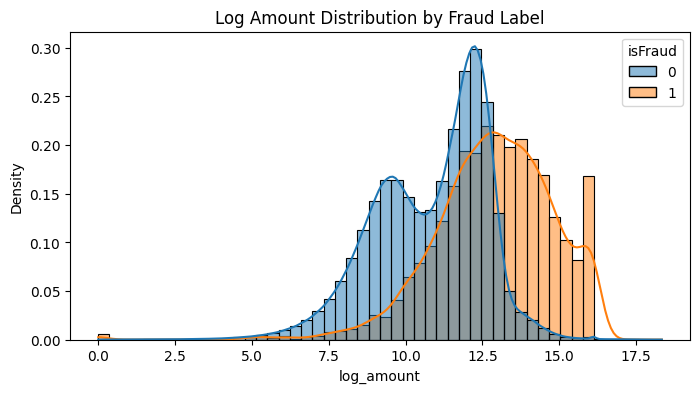

In [32]:
plt.figure(figsize=(8,4))
sns.histplot(
    data=df,
    x="log_amount",
    hue="isFraud",
    bins=50,
    kde=True,
    stat="density",
    common_norm=False
)
plt.title("Log Amount Distribution by Fraud Label")
plt.show()


## 6. Class Imbalance Handling


In [33]:
scale_pos = (y_train == 0).sum() / (y_train == 1).sum()
print("Scale pos weight:", scale_pos)


Scale pos weight: 1284.702450113665


## 7. Base Models


In [34]:
lr = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1
)

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)

lgbm = lgb.LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=64,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos,
    random_state=42,
    n_jobs=-1
)


## 8. Voting Ensemble Model

Soft voting combines probability outputs from multiple models,
improving recall on complex fraud patterns.


In [35]:
voting_model = VotingClassifier(
    estimators=[
        ("lr", lr),
        ("rf", rf),
        ("lgbm", lgbm),
    ],
    voting="soft",
    n_jobs=-1
)

print("Training Voting Classifier...")
voting_model.fit(X_train, y_train)


Training Voting Classifier...


,"estimators estimators: list of (str, estimator) tuplesInvoking the ``fit`` method on the ``VotingClassifier`` will fit clonesof those original estimators that will be stored in the class attribute``self.estimators_``. An estimator can be set to ``'drop'`` using:meth:`set_params`... versionchanged:: 0.21 ``'drop'`` is accepted. Using None was deprecated in 0.22 and support was removed in 0.24.","[('lr', ...), ('rf', ...), ...]"
,"voting voting: {'hard', 'soft'}, default='hard'If 'hard', uses predicted class labels for majority rule voting.Else if 'soft', predicts the class label based on the argmax ofthe sums of the predicted probabilities, which is recommended foran ensemble of well-calibrated classifiers.",'soft'
,"weights weights: array-like of shape (n_classifiers,), default=NoneSequence of weights (`float` or `int`) to weight the occurrences ofpredicted class labels (`hard` voting) or class probabilitiesbefore averaging (`soft` voting). Uses uniform weights if `None`.",None
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for ``fit``.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionadded:: 0.18",-1
,"flatten_transform flatten_transform: bool, default=TrueAffects shape of transform output only when voting='soft'If voting='soft' and flatten_transform=True, transform method returnsmatrix with shape (n_samples, n_classifiers * n_classes). Ifflatten_transform=False, it returns(n_classifiers, n_samples, n_classes).",True
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting will be printed as itis completed... versionadded:: 0.23",False
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001


## 9. Model Evaluation


In [36]:
y_prob = voting_model.predict_proba(X_test)[:, 1]
y_pred = (y_prob > 0.3).astype(int) 

roc = roc_auc_score(y_test, y_prob)
print("ROC-AUC:", roc)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)
print("PR-AUC:", pr_auc)


ROC-AUC: 0.9981695992121975

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.98      0.99   1268270
           1       0.12      0.97      0.22      4254

    accuracy                           0.98   1272524
   macro avg       0.56      0.97      0.60   1272524
weighted avg       1.00      0.98      0.99   1272524

Confusion Matrix:
 [[1239258   29012]
 [    132    4122]]
PR-AUC: 0.8737418134996777


In [37]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.98      0.99   1268270
           1       0.12      0.97      0.22      4254

    accuracy                           0.98   1272524
   macro avg       0.56      0.97      0.60   1272524
weighted avg       1.00      0.98      0.99   1272524



## 10. Save Model and Encoder


In [38]:
joblib.dump(voting_model, "fraud_voting_model.joblib")
joblib.dump(encoder, "type_encoder.joblib")

print("Saved:")
print("fraud_voting_model.joblib")
print("type_encoder.joblib")


Saved:
fraud_voting_model.joblib
type_encoder.joblib


## Model Performance Visualisation
### 10.1 ROC Curve


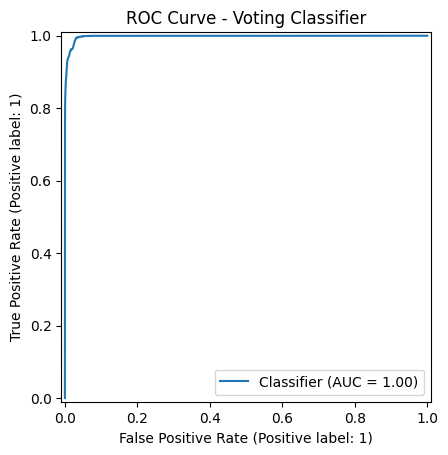

In [39]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("ROC Curve - Voting Classifier")
plt.show()


### 10.2 Precision–Recall Curve

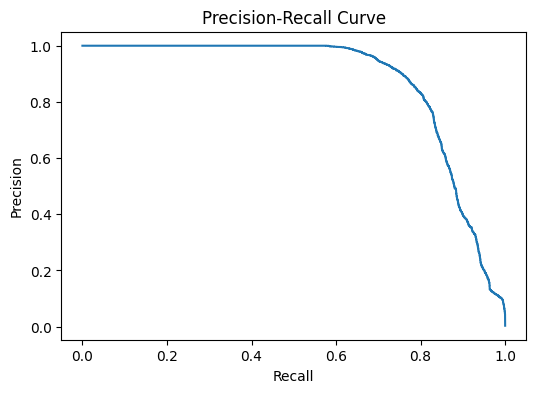

In [40]:
precision, recall, _ = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(6,4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()


### 10.3 Confusion Matrix


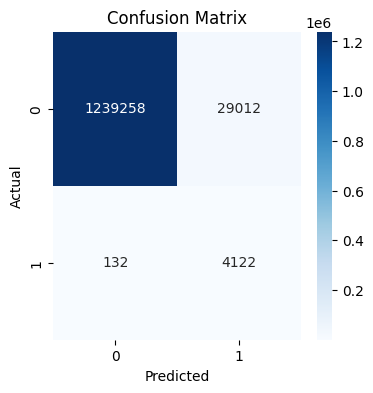

In [41]:
plt.figure(figsize=(4,4))
sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## 11. Reload Test


In [42]:
model_loaded = joblib.load("fraud_voting_model.joblib")
encoder_loaded = joblib.load("type_encoder.joblib")

print("Model reload successful")


Model reload successful
